## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [2]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [3]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [4]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [5]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [6]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [7]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

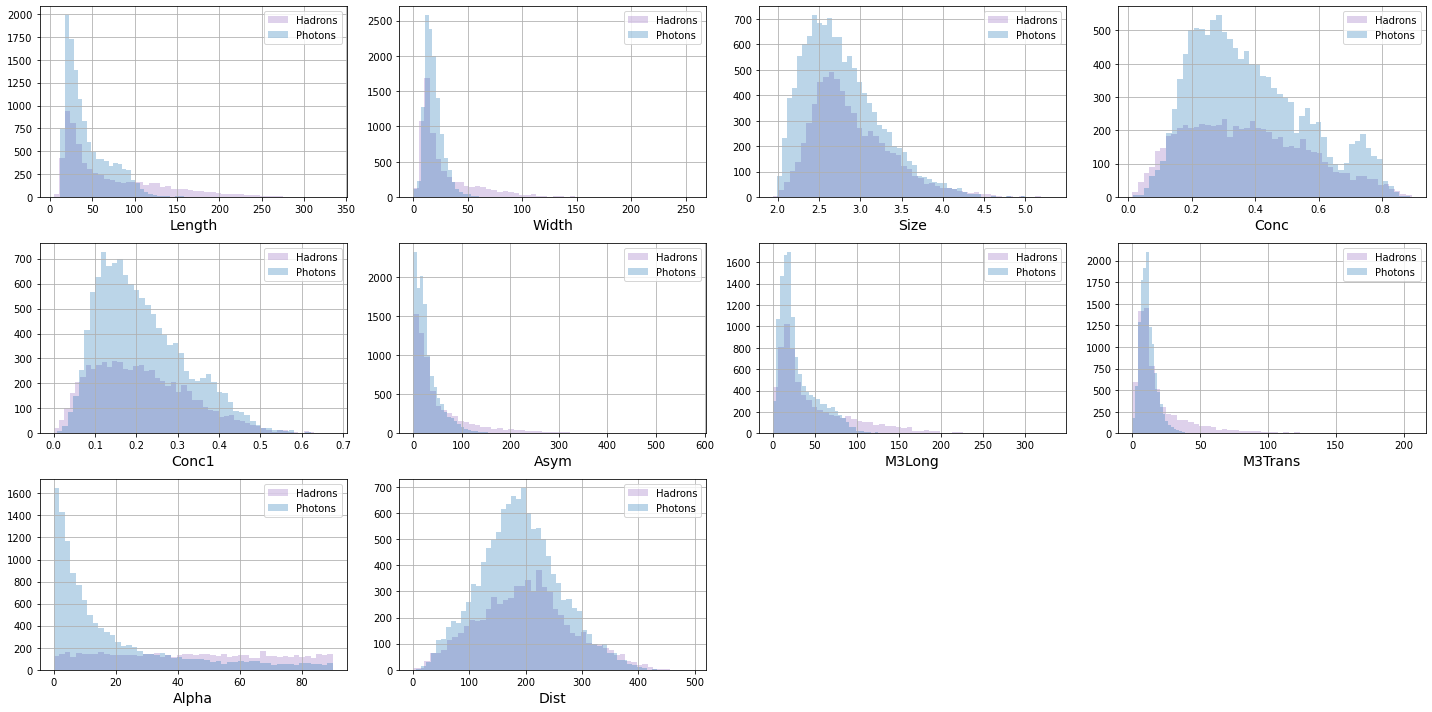

In [8]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [9]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

Text(0.5, 1.0, 'Test distribution')

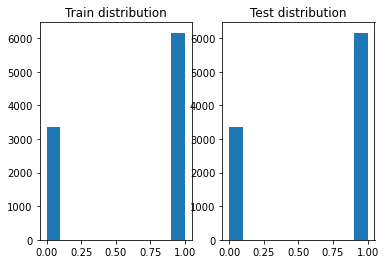

In [10]:
fig, axs = plt.subplots(1, 2)
axs[0].hist(y_train, bins=None)
axs[0].set_title('Train distribution')
axs[1].hist(y_test, bins=None)
axs[1].set_title('Test distribution')

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [11]:
from sklearn.preprocessing import QuantileTransformer
#X_train = np.sort(X_train, axis=0)
#X_test = np.sort(X_test, axis=0)
qt = QuantileTransformer(random_state=0, output_distribution='normal')
X_train = qt.fit_transform(X_train) 
X_test = qt.transform(X_test)

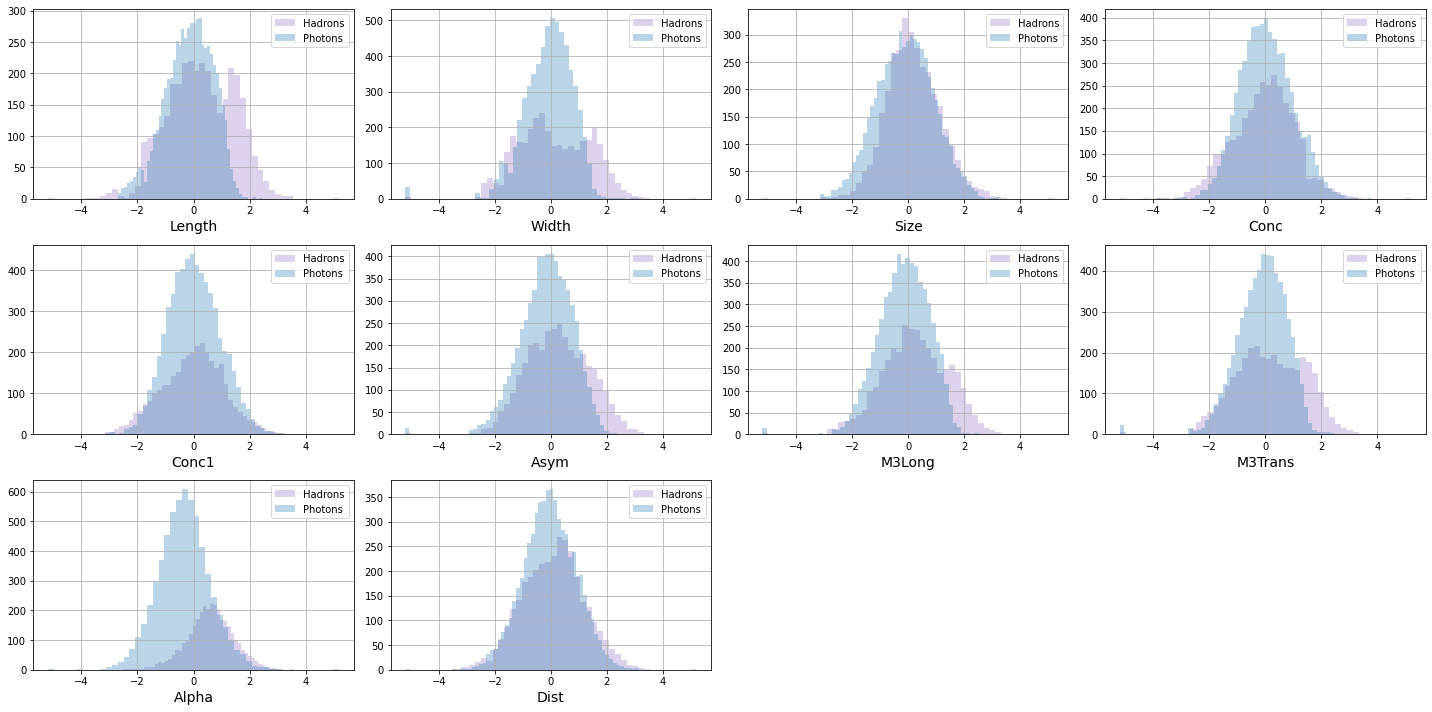

In [12]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

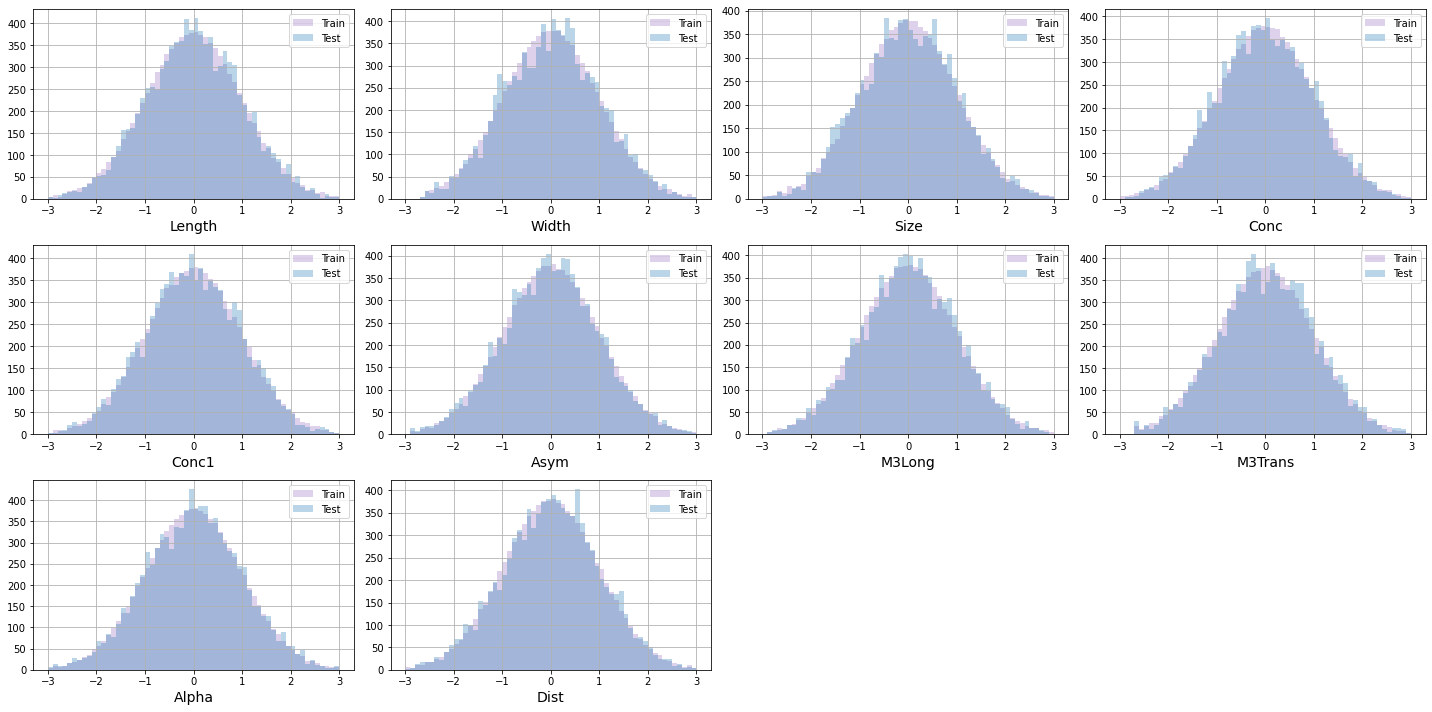

In [13]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
DEVICE

device(type='cpu')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [16]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.model = nn.Sequential(
            # 1 слой
            nn.Linear(self.n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            # 2 слой
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            # 3 слой
            nn.Linear( 100, self.n_outputs),
            )
        ### THE END OF YOUR CODE ###
    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.model(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [17]:
def generate(generator, y, latent_dim):
    ### YOUR CODE IS HERE ######
    z_noise = torch.normal(0, 1, (y.shape[0], latent_dim))
    X_fake = generator(z_noise, y)
    ### THE END OF YOUR CODE ###
    return X_fake  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

В семинаре мы используем функцию активации - Sigmoid, она выдает вероятности классов, однако в нашем случае нам необходимо, чтобы дискриминатор выдавал сами классы 0 и 1. Нам нужны именно классы, так как далее мы используем эти выходы при подсчете лосса (вероятности тут нерелевантны), поэтому данная функция активации нам не нужна.

In [18]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.discrim = nn.Sequential(
            # 1 слой
            nn.Linear(n_inputs, 100),
            nn.ReLU(True),
            # 2 слой
            nn.Linear(100, 100),
            nn.ReLU(True),
            # 3 слой
            nn.Linear(100, 1),
            #nn.Sigmoid()
            )
        ### THE END OF YOUR CODE ###

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.discrim(xy)

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель линейной регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

Больше всего нас удовлетворило бы значение accuracy **равное 0.5**. Так как мы в дальнейшем будем брать в обучение реальные и фейковые объекты в равном количестве, значение 0.5 означает то, что классификатор верно определяет реальные объекты, как реальные (относит их к классу 1 - real), и ошибается при определении фейковых объектов (относит их к классу 1 - real). Такого результата мы и добиваемся: генерим такие объекты с помощью генератора, чтобы классификатор не мог отличить их реальных.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [20]:
def other_agent_score(X_real, y_real, X_fake, y_fake):
    ### YOUR CODE IS HERE ######
    
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_real, y_real, stratify = y_real, test_size=0.25, shuffle = True, random_state = 11
    )
    
    X_fake_train, X_fake_test, y_fake_train, y_fake_test = train_test_split(
    X_fake, y_fake, stratify = y_fake, test_size=0.25, shuffle = True, random_state = 11
    )
    
    train_Xset = torch.cat((X_real_train, X_fake_train), 0)
    test_Xset = torch.cat((X_real_test, X_fake_test), 0)
    train_yset = torch.cat((y_real_train, y_fake_train), 0)
    test_yset = torch.cat((y_real_test, y_fake_test), 0)
    
    lin = LinearRegression()
    log = LogisticRegression()
    grad = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=11)
    
    lin_reg = lin.fit(train_Xset.detach().numpy(), train_yset.detach().numpy())
    log_reg = log.fit(train_Xset.detach().numpy(), train_yset.detach().numpy())
    boosting = grad.fit(train_Xset.detach().numpy(), train_yset.detach().numpy())
    
    log_reg_pred = log_reg.predict(test_Xset.detach().numpy())
    lin_reg_pred = lin_reg.predict(test_Xset.detach().numpy())
    lin_reg_pred[lin_reg_pred>0.5] = 1
    lin_reg_pred[lin_reg_pred<=0.5] = 0
    #boosting_pred = boosting.predict(test_Xset.detach().numpy())

    log_reg_score = accuracy_score(test_yset, log_reg_pred)
    lin_reg_score = accuracy_score(test_yset, lin_reg_pred)
    boosting_score = boosting.score(test_Xset.detach().numpy(), test_yset.detach().numpy())
    ### THE END OF YOUR CODE ###
    print('Linear regression score: ' + str(lin_reg_score))
    print('Boosting score: ' + str(boosting_score))

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Подсказка 1: не забывайте ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора.
- Подсказка 2: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 3: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [21]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.generate = generate
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []
        
        iter_i = 0

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE #####

                # generate a batch of fake observations
                fake_batch = self.generate(self.generator, cond_batch, self.latent_dim)
                    
                ### Generator
                if iter_i % self.n_critic == 0:
                    
                    # measures generator's ability to fool the discriminator
                    self.opt_gen.zero_grad()
                    loss_gen = - torch.mean(self.discriminator(fake_batch, cond_batch))
                    # optimization step
                    
                    loss_gen.backward(retain_graph=True)
                    self.opt_gen.step()
                    
                else:
                    ### Discriminator
                    self.opt_disc.zero_grad()
                    # measure discriminator's ability to classify real from fake samples
                    loss_disc = -torch.mean(self.discriminator(real_batch, cond_batch)) + torch.mean(self.discriminator(fake_batch, cond_batch))
                    # optimization step

                    loss_disc.backward(retain_graph=True)
                    self.opt_disc.step()

                    # Clip weights of discriminator
                    for p in discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)
                    
                iter_i += 1
                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())
            
            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустите работу фукнции other_agent_score
            
            ### YOUR CODE IS HERE ######
            
            x_real = X_real[:1000]
            x_fake = X_fake[:1000]
            y_real = torch.ones([1000, 1], dtype=torch.float, device=DEVICE)
            y_fake = torch.zeros([1000, 1], dtype=torch.float, device=DEVICE)
            other_agent_score(x_real, y_real, x_fake, y_fake)
            
            ### THE END OF YOUR CODE ###
            
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Linear regression score: 0.808
Boosting score: 0.936
Linear regression score: 0.618
Boosting score: 0.884
Linear regression score: 0.596
Boosting score: 0.884
Linear regression score: 0.546
Boosting score: 0.846
Linear regression score: 0.564
Boosting score: 0.792
Linear regression score: 0.568
Boosting score: 0.732
Linear regression score: 0.606
Boosting score: 0.744
Linear regression score: 0.548
Boosting score: 0.68
Linear regression score: 0.524
Boosting score: 0.65
Linear regression score: 0.552
Boosting score: 0.66
Linear regression score: 0.536
Boosting score: 0.61
Linear regression score: 0.546
Boosting score: 0.598
Linear regression score: 0.52
Boosting score: 0.564
Linear regression score: 0.5
Boosting score: 0.59
Linear regression score: 0.512
Boosting score: 0.584
Linear regression score: 0.52
Boosting score: 0.594
Linear regression score: 0.54
Boosting score: 0.584
Linear regression score: 0.494
Boosting score: 0.532
Linear regression score: 0.534
Boosting score: 0.572
Lin

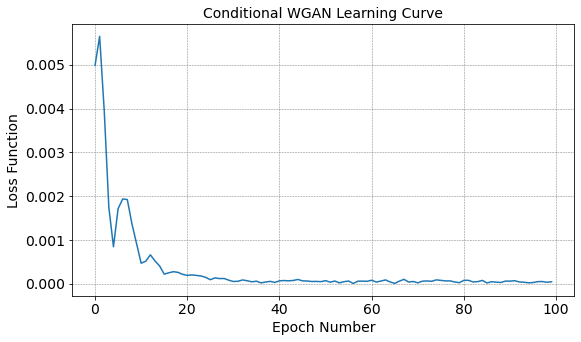

In [24]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [25]:
### YOUR CODE IS HERE ######
train = qt.inverse_transform(X_train) 
test = qt.inverse_transform(X_test)
### THE END OF YOUR CODE ###

In [26]:
y_train = torch.tensor(y_train, dtype=torch.float, device=DEVICE)
X_fake_train = generate(fitter.generator, y_train, latent_dim).detach().numpy()
X_fake_train = qt.inverse_transform(X_fake_train)

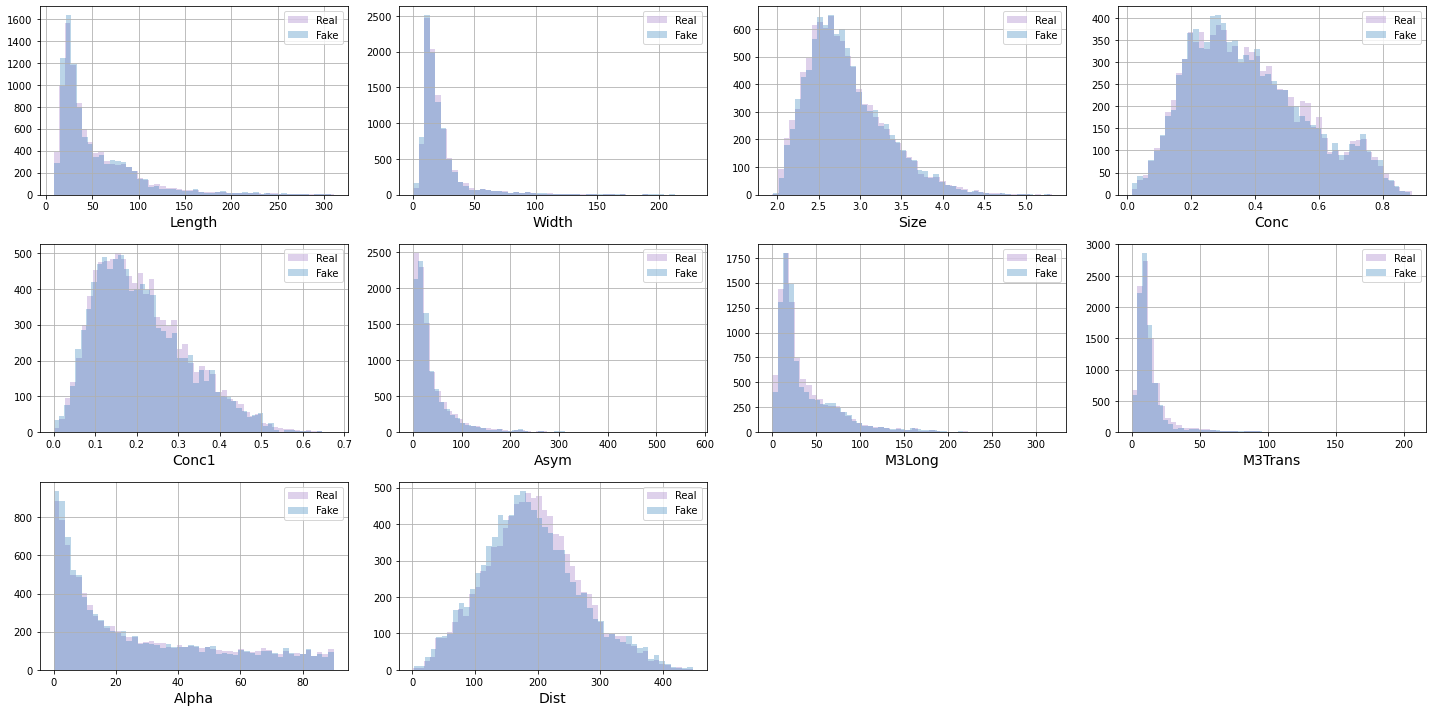

In [27]:
plot_hists(train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [28]:
y_test = torch.tensor(y_test, dtype=torch.float, device=DEVICE)
X_fake_test = generate(fitter.generator, y_test, latent_dim).detach().numpy()
X_fake_test = qt.inverse_transform(X_fake_test)

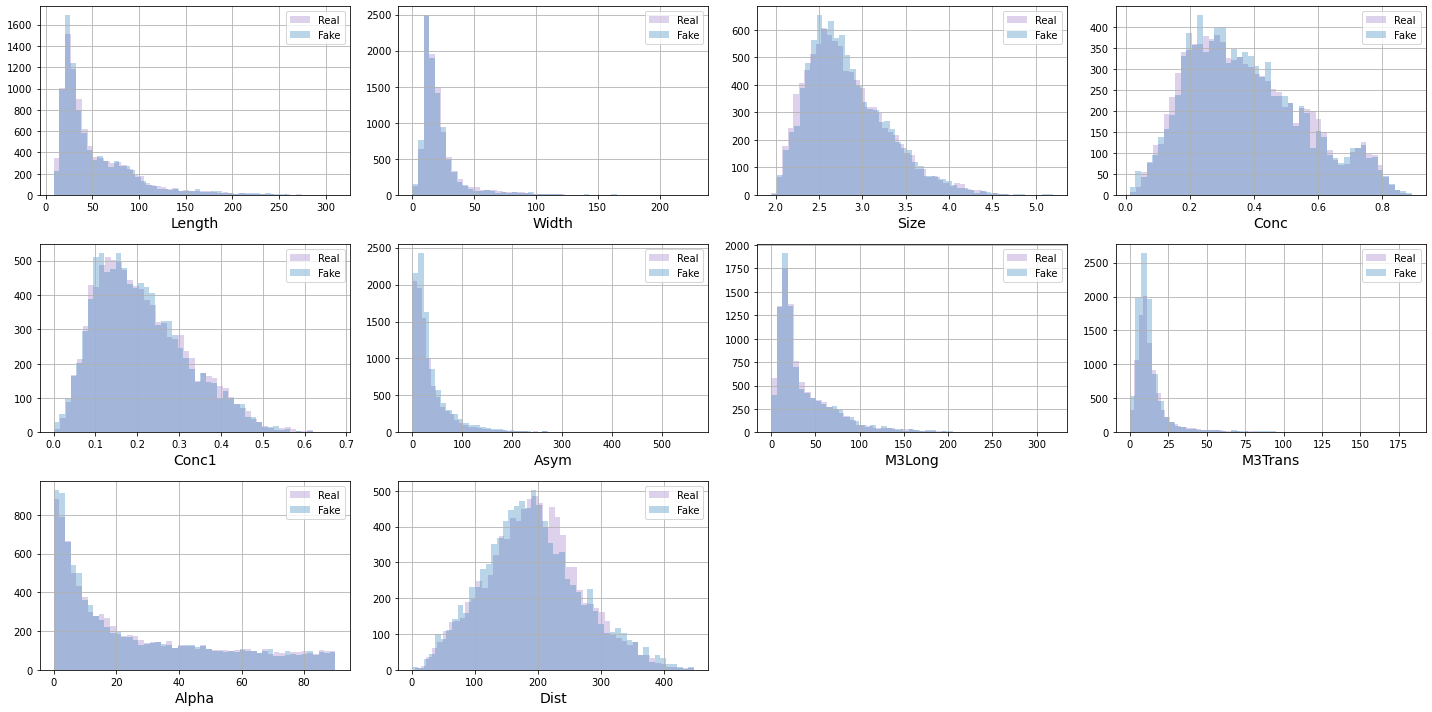

In [29]:
plot_hists(test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [30]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, train), axis=0)
XX_test = np.concatenate((X_fake_test, test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [32]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7090154643791857


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


Мы имеем реальные объекты. Создаем шум и с помощью CGAN (совместной работы генератора и дискриминатора) производим фейковые объекты. Нашей задачей является создать настолько похожие фейковые объекты на реальные, что классификатор выдавал бы accuracy и ROC-AUC равными 0.5, то есть не мог отличить сгенерированные объекты от имевшихся. Когда мы обучили генератор создавать похожие объекты, проверяем с помощью линрега и бустинга, как успешно классификатор выявляет фэйки. После этого 

Нам необходимо, чтобы ROC-AUC был равен **0.5**, так как данное значение показывает, что это наихудшая модель и делает предсказания рандомно. У нас получилось **0.68**, это означает, что классификатор верно определяет класс некоторых объектов. Иной интерпретацией AUC-ROC является вероятность модели отличить два класса между собой.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [33]:
def corrupt(x, amount):
    ### YOUR CODE IS HERE ######\
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1)
    x = x*(1-amount) + noise*amount 
    ### THE END OF YOUR CODE ###
    return x

## Добавим sсheduler, он пригодится вам при обучении модели

In [34]:
!pip install -q diffusers --user

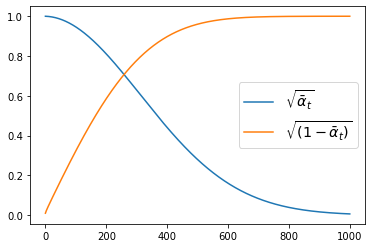

In [35]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?). 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [36]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.dif_gen = nn.Sequential(
            # 1 слой
            nn.Linear(self.n_inputs, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(True),
            # 2 слой
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            # 3 слой
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(True),
            # 4 слой
            nn.Linear(50, self.n_outputs),
            )
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.dif_gen(zy)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [37]:
def generate_with_diffusion(model, x, y, latent_dim, noise_scheduler):

    noise = torch.randn_like(x)
    timesteps = torch.randint(0, 999, (len(y),)).long()
    noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
    X_fake = model(noisy_x, y)

    return X_fake  # numpy

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [38]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        self.loss_fn = nn.MSELoss()

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []
        self.losses = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######

                # Get some data and prepare the corrupted version
                real_batch = real_batch.to(device=DEVICE)
                cond_batch = cond_batch.to(device=DEVICE)
                noise = torch.randn_like(real_batch)
                timesteps = torch.randint(0, 999, (real_batch.shape[0],)).long().to(device=DEVICE)
                noisy_x = noise_scheduler.add_noise(real_batch, noise, timesteps)
                
                pred = self.model.forward(noisy_x, cond_batch)

                # Calculate the loss
                loss = self.loss_fn(pred, noise) # How close is the output to the noise

                # Backprop and update the params:
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()

                # Store the loss for later
                self.losses.append(loss.item())
                
                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            
            self.loss_history.append(sum(self.losses)/len(self.losses))
            self.losses = []
            
            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустите работу фукнции other_agent_score
            
            x_fake = generate_with_diffusion(self.model, X_real[:1000], y_cond[:1000], self.latent_dim, noise_scheduler)
            x_real = X_real[:1000]
            
            y_real = torch.ones([1000, 1], dtype=torch.float, device=DEVICE)
            y_fake = torch.zeros([1000, 1], dtype=torch.float, device=DEVICE)
            
            other_agent_score(x_real, y_real, x_fake, y_fake)
            ### THE END OF YOUR CODE ###
            
        # Turn off training
        self.model.train(False)

In [39]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

Linear regression score: 0.54
Boosting score: 0.732
Linear regression score: 0.488
Boosting score: 0.68
Linear regression score: 0.5
Boosting score: 0.606
Linear regression score: 0.49
Boosting score: 0.612
Linear regression score: 0.494
Boosting score: 0.616
Linear regression score: 0.468
Boosting score: 0.574
Linear regression score: 0.488
Boosting score: 0.632
Linear regression score: 0.49
Boosting score: 0.606
Linear regression score: 0.488
Boosting score: 0.552
Linear regression score: 0.476
Boosting score: 0.624
Linear regression score: 0.494
Boosting score: 0.572
Linear regression score: 0.496
Boosting score: 0.562
Linear regression score: 0.47
Boosting score: 0.572
Linear regression score: 0.51
Boosting score: 0.596
Linear regression score: 0.516
Boosting score: 0.578
Linear regression score: 0.514
Boosting score: 0.608
Linear regression score: 0.516
Boosting score: 0.568
Linear regression score: 0.494
Boosting score: 0.578
Linear regression score: 0.504
Boosting score: 0.566
L

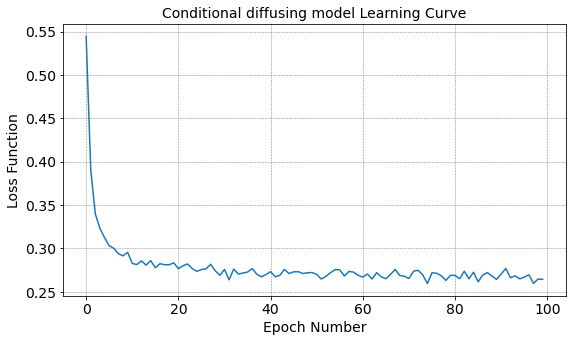

In [40]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [41]:
### YOUR CODE IS HERE ######
train_dif = qt.inverse_transform(X_train) 
test_dif = qt.inverse_transform(X_test)
### THE END OF YOUR CODE ###

In [42]:
y_train = torch.tensor(y_train, dtype=torch.float, device=DEVICE)
X_train = torch.tensor(X_train, dtype=torch.float, device=DEVICE)
X_fake_train_dif = generate_with_diffusion(diffusionFitter.model, X_train, y_train, latent_dim, noise_scheduler).detach().numpy()
X_fake_train_dif = qt.inverse_transform(X_fake_train_dif)

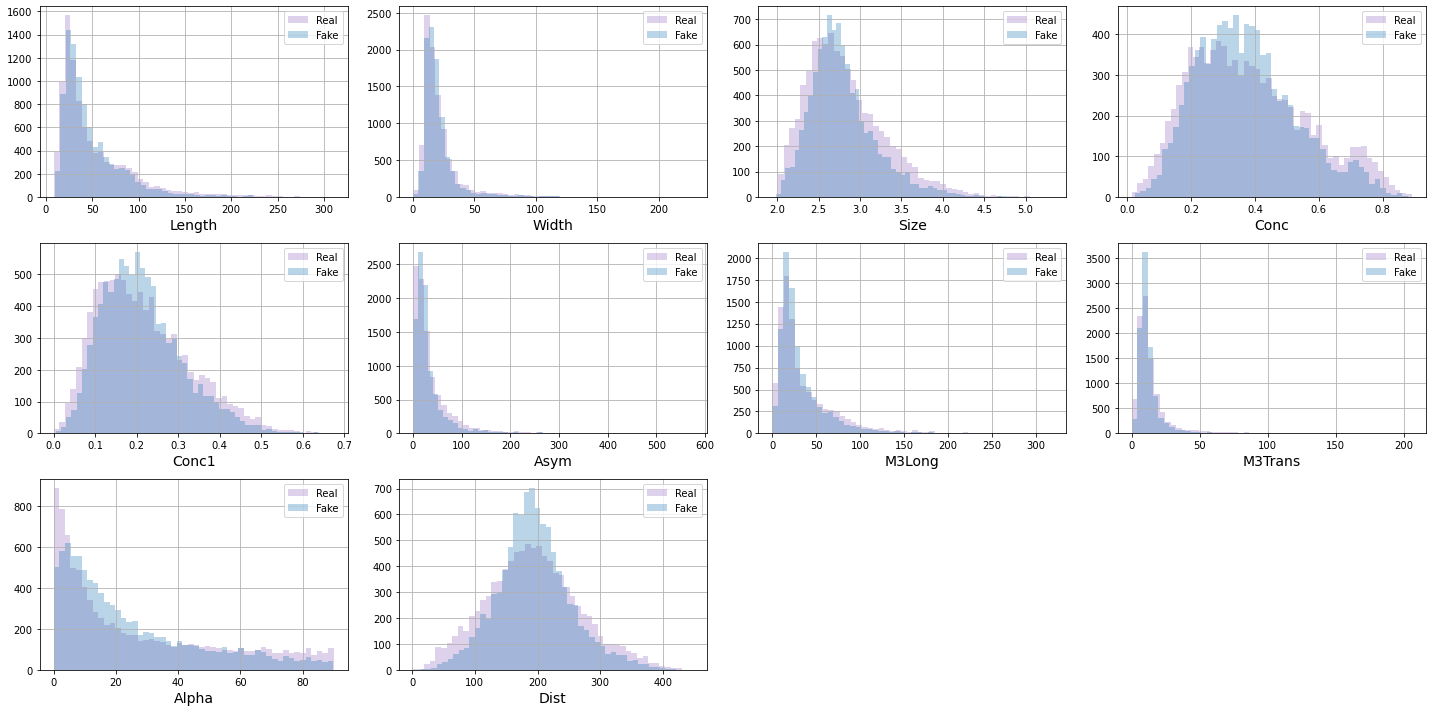

In [43]:
plot_hists(train_dif, X_fake_train_dif, names, label1="Real", label2="Fake", bins=50)

In [44]:
y_test = torch.tensor(y_test, dtype=torch.float, device=DEVICE)
X_test = torch.tensor(X_test, dtype=torch.float, device=DEVICE)
X_fake_test_dif = generate_with_diffusion(diffusionFitter.model, X_test, y_test, latent_dim, noise_scheduler).detach().numpy()
X_fake_test_dif = qt.inverse_transform(X_fake_test_dif)

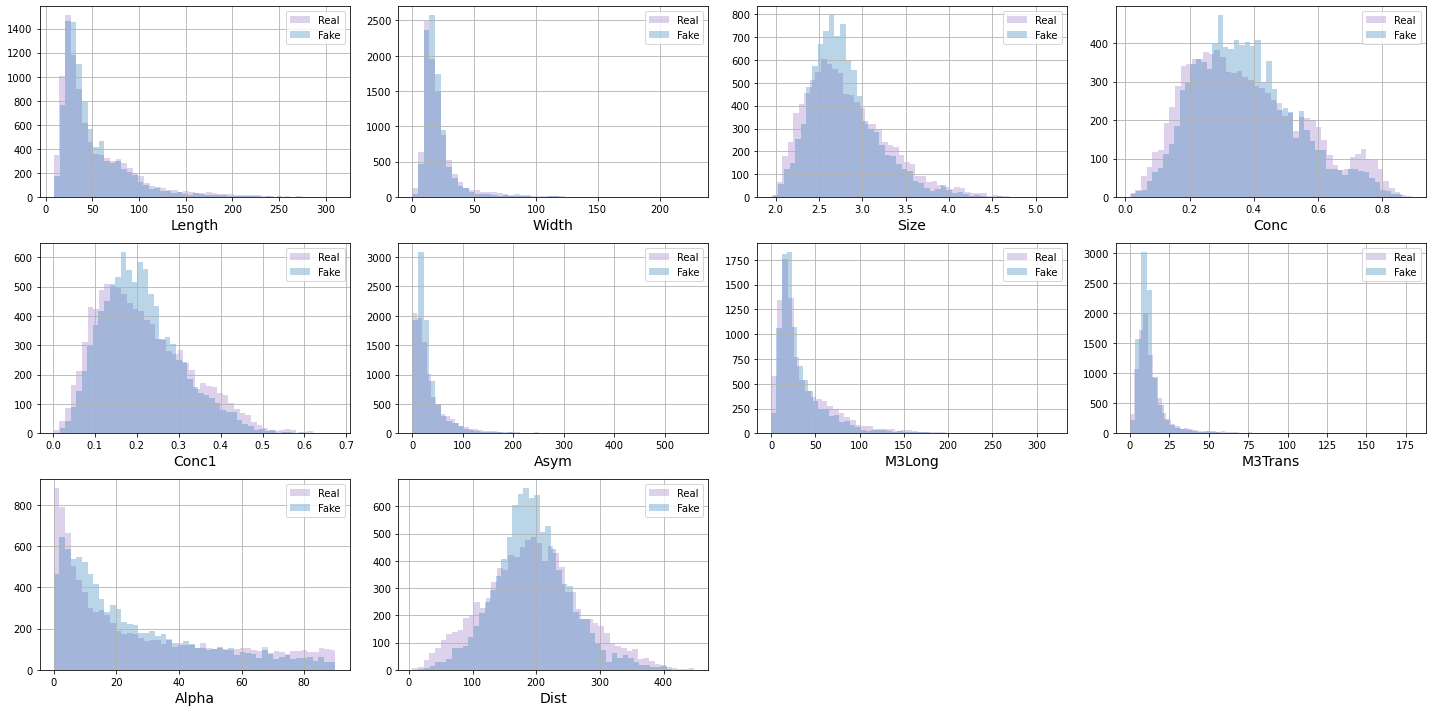

In [45]:
plot_hists(test_dif, X_fake_test_dif, names, label1="Real", label2="Fake", bins=50)

In [46]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train_dif, train_dif), axis=0)
XX_test = np.concatenate((X_fake_test_dif, test_dif), axis=0)

yy_train = np.array([0] * len(X_fake_train_dif) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test_dif) + [1] * len(X_test))

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [48]:
from sklearn.metrics import roc_auc_score
accur = accuracy_score(yy_test, (yy_test_proba>0.5).astype('int'))
auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)
print('Accuracy = ', accur)

ROC AUC =  0.9797966278232775
Accuracy =  0.9217665615141956


В диффузионной модели аналогичная задача, генерировать объекты наиболее похожие на реальные данные. Однако отличается подход. В GAN мы формировали шум из рандомного тензора, преобразовывали его в новый объект с помощью генератора. Здесь же мы берем реальный объект и зашумляем его, с каждым шагом все сильнее так, что он сам становится шумом. Далее с помощью генератора стараемся обратно восстановить объект - получаем фэйк. Затем с помощью классификатора смотрим, как модель различает фэйки и реальные объекты, ожидаем экюраси и рок-аук 0.5, как и ранее. Так как здесь оба rритерия больше, чем в GANе, то можем сказать, что генерация с помощью гана показала себя лучше, так как классификация смогла выявить гораздо меньше фейков, чем в диффузии. Значительно больше фэйков из GANа стали для модели реальными объектами, чем фэйки из Diffusion.

Пробовал несколько раз менять архитектуры, ошибки и нелинейность, изменения незначительны. Использовал в итоге MSE loss.

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!